In [49]:
#### %matplotlib notebook
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
import argparse
import os
from collections import defaultdict

DIV=1048576

sns.set_style('whitegrid')

def read_directory(directory):
    total_bps = 0
    total_i = 0

    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None

    g = glob(directory + '/client_*.out')
    if len(g) == 0:
        g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None

    for file in g:
        try:
            j = json.load(open(file))
            if 'sum_received' in j['end']:
                bps = j['end']['sum_sent']['bits_per_second']
            elif 'sum' in j['end']:
                bps = j['end']['sum']['bits_per_second']
            else:
                raise Exception("No sum or sum_sent")
        except Exception as e:
            print('error', file, e)
            continue
        total_bps += bps
        total_i += 1

    if total_bps == 0:
        return None, None

    print('{}({}): {} Mbps'.format(directory, total_i, total_bps / DIV ))

    return drop_rate, total_bps / DIV

def make_mean_and_error(vals):
    vals = np.array(vals) / 1024
    mean = np.median(vals)
    lowerr = mean - min(vals)
    higherr = max(vals) - mean

    return mean, (lowerr, higherr)

def make_plot(fecs, no_fecs, title=None, sv=None):

    fec_by_rate = defaultdict(list)
    nofec_by_rate = defaultdict(list)

    for dir in fecs:
        r, val = read_directory(dir)
        if r is not None:
            fec_by_rate[r].append(val)

    for dir in no_fecs:
        r, val = read_directory(dir)
        if r is not None:
            nofec_by_rate[r].append(val)

    if len(fec_by_rate) != len(nofec_by_rate):
        print("WARNING: {} fec, {} nofec".format(len(fec_by_rate), len(nofec_by_rate)))

    rates, base_vals, base_errs, fec_vals, fec_errs =  \
            [], [], [], [], []

    for rate in sorted(set(fec_by_rate.keys()) & set(nofec_by_rate.keys())):
        rates.append(rate)

        m, e = make_mean_and_error(fec_by_rate[rate])

        fec_vals.append(m)
        fec_errs.append(e)

        m, e = make_mean_and_error(nofec_by_rate[rate])

        base_vals.append(m)
        base_errs.append(e)

    x = np.arange(len(rates))

    labels = [str(rate * 100) + "%" if rate > 0 else '0%' for rate in rates]

    ax = plt.gca()
    
    #ax.bar(x, base_vals, width=.25, tick_label=labels, label="No FEC")
    ax.bar(x, base_vals, width=.23, yerr=np.array(base_errs).T, tick_label=labels, label="Baseline", color=[.4,.4,.4], edgecolor='k')
    #ax.bar(x+.3, fec_vals, width=.25, label="FEC")
    ax.bar(x+.3, fec_vals, width=.23, yerr=np.array(fec_errs).T, label="FEC", color=[.8,.8,.8], edgecolor='k')
    plt.legend()
    ax.set_ylabel("Throughput (Gbps)")
    ax.set_xlabel("Drop rate")

    if title is not None:
        plt.title(title)

    if sv:
        plt.savefig(sv)

    plt.show()


<IPython.core.display.Javascript object>


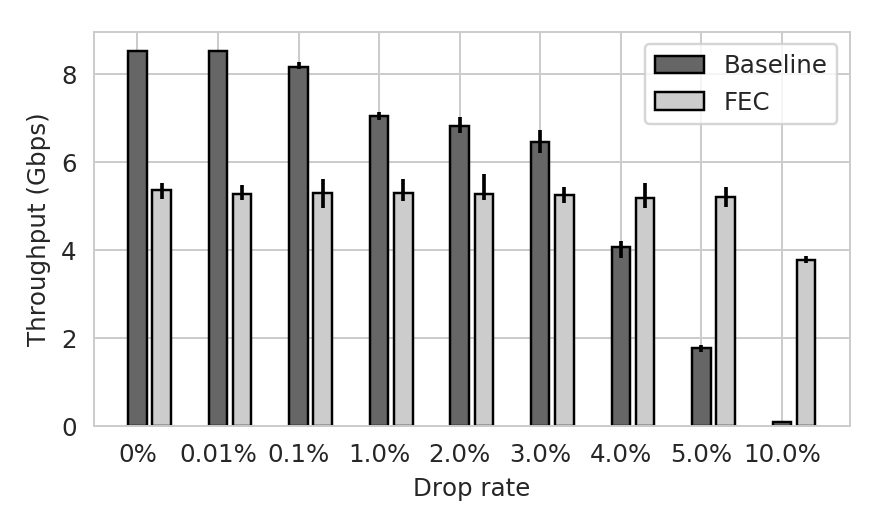

../iperf_output/fec/iperf_0.05_fec_2(10): 5458.57089530508 Mbps
../iperf_output/fec/iperf_0_fec_6(10): 5343.553787649166 Mbps
../iperf_output/fec/iperf_0.05_fec_1(10): 5322.98763992497 Mbps
../iperf_output/fec/iperf_0.02_fec_4(10): 5542.636802839517 Mbps
../iperf_output/fec/iperf_0.0001_fec_8(10): 5407.69291555919 Mbps
../iperf_output/fec/iperf_0.01_fec_1(10): 5410.025865977106 Mbps
../iperf_output/fec/iperf_0_fec_5(10): 5528.3385271212 Mbps
../iperf_output/fec/iperf_0.001_fec_4(10): 5490.278072495175 Mbps
../iperf_output/fec/iperf_0.04_fec_4(10): 5076.2079882591115 Mbps
../iperf_output/fec/iperf_0_fec_8(10): 5495.74125538763 Mbps
../iperf_output/fec/iperf_0.1_fec_3(10): 3878.3330935123586 Mbps
../iperf_output/fec/iperf_0.01_fec_10(10): 5253.942401443749 Mbps
../iperf_output/fec/iperf_0.04_fec_2(10): 5654.582279290675 Mbps
../iperf_output/fec/iperf_0.01_fec_3(10): 5431.01551378859 Mbps
../iperf_output/fec/iperf_0.1_fec_1(10): 3791.509475931678 Mbps
../iperf_output/fec/iperf_0.1_fec_6(1

../iperf_output/nofec/iperf_0.1_nofec_3(10): 91.18234296164806 Mbps
../iperf_output/nofec/iperf_0.03_nofec_3(10): 6395.009855217452 Mbps
../iperf_output/nofec/iperf_0.02_nofec_3(10): 7076.867221156173 Mbps
../iperf_output/nofec/iperf_0_nofec_7(10): 8732.142281568682 Mbps
../iperf_output/nofec/iperf_0.001_nofec_2(10): 8382.976927991771 Mbps
../iperf_output/nofec/iperf_0.03_nofec_7(10): 6353.294760396273 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_10(10): 8728.94797035461 Mbps
../iperf_output/nofec/iperf_0_nofec_10(10): 8731.682641421 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_6(10): 8729.866276131555 Mbps
../iperf_output/nofec/iperf_0.02_nofec_4(10): 6904.582727390188 Mbps
../iperf_output/nofec/iperf_0.001_nofec_3(10): 8331.202087722115 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_4(10): 8729.801339016503 Mbps
../iperf_output/nofec/iperf_0.04_nofec_3(10): 4181.386389202736 Mbps
../iperf_output/nofec/iperf_0.01_nofec_6(10): 7119.561660080441 Mbps
../iperf_output/nofec/iperf_0_nofec

In [51]:
fec_files = glob('../iperf_output/fec/*')
nofec_files = glob('../iperf_output/nofec/*')

plt.figure(figsize=(5, 3))
make_plot(fec_files, nofec_files)
plt.tight_layout()
plt.savefig("FEC.pdf")

In [13]:
5400 / 8700

0.6206896551724138